# 04 - Training Models

In [1]:
# -- Setup -- #

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures (not done in Ch. 02-03)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Linear Regression

Linear regression model prediction

$$\hat{\mathbf{y}} = h_\theta(\bf x) = \mathbf{\theta}^T \mathbf{x}$$

$\theta$ : *parameter vector*, bias term $\theta_0$\n

$\mathbf x$ : *feature vector*, $x_0 = 1$

$h_\theta$ : *hypothesis fn*, w/ model params $\theta$

MSE of a Linear Regression hypothesis $h_\theta$ on a training set $\mathbf X$

$$MSE(\theta) = \frac1m \sum_m \left( \theta^T\mathbf{x^{(i)}} - y^{(i)}\right)^2$$

### The Normal Equation

Closed form solution for $\theta$

$\hat{\mathbf{\theta}} = (\mathbf{X}^T\mathbf X)^{-1} \mathbf{X}^T y$

Let's generate some 'linear' data to test regression upon.

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


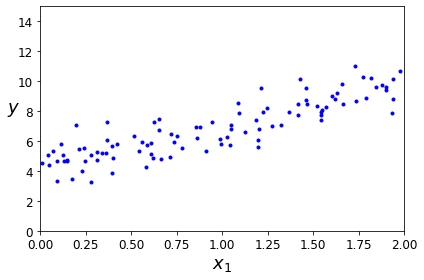

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Compute $\hat \theta$ using normal eq. Use `inv` from `np.linalg`

In [8]:
# Form x_0 component
X_b = np.c_[np.ones((100, 1)), X] # np.c_ translates slice objs to concat. along second axis
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

Note model is $y = 4 + 3x + \epsilon$, w/ $\epsilon$ normally distributed. We see we get close to expected params

In [9]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [10]:
# Make predictions
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best) # hypothesis fn.
y_predict

array([[4.21509616],
       [9.75532293]])

Saving figure linear_model_predictions_plot


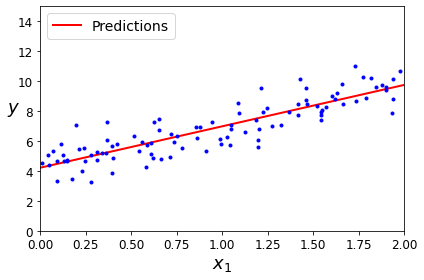

In [14]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

Lin. Reg. is easily implemented in sklearn

In [15]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [16]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In fact, `LinearRegression` is based upon `scipy.linalg.lstsq()`

In [17]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

`lstsq` computes the *psuedo inverse* $\bf{X}^+$ within $\hat\theta = \bf X^\dagger \bf y$. Psuedo inv. can be directly calculated via `np.linalg.pinv`. Details not too important but psuedo inverse is more computationally efficient (from matrix factorization via SVD Singular Value Decomposition) and robust in comparison to normal eq.

In [18]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

### Computational Complexity

As alluded to above, the normal eqn, computing inverse of $\mathbf X^T \mathbf X$ is $\mathcal O(n^{2.4})$ - $\mathcal O(n^3)$. SVD approach is $\mathcal O(n^2)$. Worth noting that both are $\mathcal O(m)$ where $m$ is size of training set. When training set size or number of features are too large, need iterative method like grad. descent.

## Gradient Descent

Tweak params iteratively to minimize cost fn. Initially randomized. 'Learning step' size is proportional to slope, so steps get smaller as minimum is approached. If learning rate is too large, may jump over minimum and diverge. See Fig 4-6, which shows generic problem of avoiding local min and also points out long time consumption at inflection plateaus.

MSE in particular is convex, continuous, *Lipschitz* continuous derivative. Thus grad. desc. is guaranteed to approach global min asymptotically (if learning rate not too high). In 2D, cost fn is elliptical bowl. As in FIg. 4-7, features with different scales take longer to converge (circular vs elliptical). I believe this is a result of a fixed learning rate. Adaptive should help. 

### Batch Gradient Descent

$\frac{\partial}{\partial \theta_j}MSE(\theta) = \frac{2}{m} \sum_i (\theta^T\mathbf x^{(i)}- y^{(i)})x^{(i)}_j$

As a single vector

$\nabla_\theta MSE = \frac{2}{m}\mathbf X^T(\bf X \theta - \mathbf y)$

Since the gradient is evaluated on the entire $\bf X$ (each step), this is why is considered __batch gradient descent__. Scales well with number of features (as compared to normal eq. or SVD)

Gradient Descent Step

$\theta^{(next\ step)} = \theta - \eta \nabla_\theta MSE(\theta)$

In [26]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [30]:
theta #matches normal eq. result

array([[4.21509616],
       [2.77011339]])

In [31]:
X_new_b.dot(theta)
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


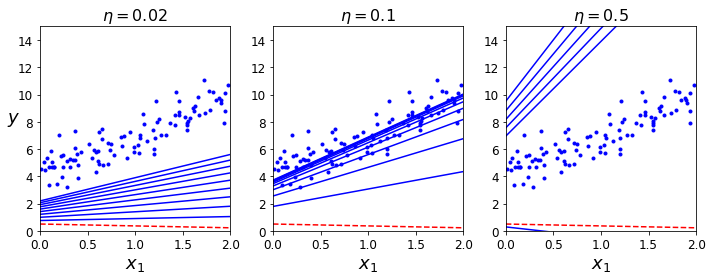

In [50]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

Different learning rates pictured above (starting with dashed red). Can use grid search to find proper learning rate. Number of iterations best terminated based on tolerance $\epsilon$ of norm of gradient vector. Author suggests (with linear regression) that convergence time is $\mathcal O(1/\epsilon)$

### Stochastic Gradient Descent

SGD picks a random (single) instance and computes its gradient, thereby consuming little memory (can be implemented as an out-of-core algorithm). When cost function is very irregular, randomness (bouncing) may be helpful to escape local minima. However, does not settle well at global min. 

To address optimizing the finding of the global min, can use a learning schedule to gradually decrease learning rate. 

SGD w/ simple learning sched. ex. Here we only go through entire training set 50 times and end up w/ similar solution as with batch gradient descent which used 1000 training set iterations.

In [40]:
X_b[2:3]

array([[1.        , 1.46398788]])

Saving figure sgd_plot


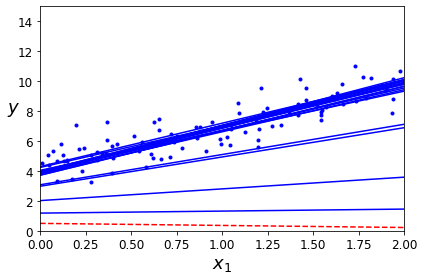

array([[4.21076011],
       [2.74856079]])

In [43]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]        # slightly different return w/ slice vs raw index
        yi = y[random_index:random_index+1]          # slightly different return w/ slice vs raw index
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown


plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()
theta

In iterating through $m$ training points, note these are selected randomly and thus some points may never be sampled in a given epoch. One could shuffle training set and iterate sequentially, but this generally converges more slowly.

On a similar note, in either case, training instances must be independent and identically distributed (IID), which can be achieved by shuffling.

To implement via sklearn we optimize the squared error loss fn. Run for 1000 epochs max OR until loss drops by less than `tol` during one epoch. Uses default learning schedule (different from earlier implem.). No regularization `penalty=None`. 

In [48]:
y.ravel()

array([ 6.33428778,  9.40527849,  8.48372443,  5.60438199,  4.71643995,
        5.29307969,  5.82639572,  8.67878666,  6.79819647,  7.74667842,
        5.03890908, 10.14821022,  8.46489564,  5.7873021 ,  5.18802735,
        6.06907205,  5.12340036,  6.82087644,  6.19956196,  4.28385989,
        7.96723765,  5.09801844,  5.75798135,  5.96358393,  5.32104916,
        8.29041045,  4.85532818,  6.28312936,  7.3932017 ,  4.68275333,
        9.53145501,  5.19772255,  4.64785995,  9.61886731,  7.87502098,
        8.82387021,  5.88791282,  7.0492748 ,  7.91303719,  6.9424623 ,
        4.69751764,  5.80238342,  5.34915394, 10.20785545,  6.34371184,
        7.06574625,  7.27306077,  5.71855706,  7.86711877,  7.29958236,
        8.82697144,  8.08449921,  9.73664501,  8.86548845,  6.03673644,
        9.59980838,  3.4686513 ,  5.64948961,  3.3519395 ,  7.50191639,
        5.54881045,  5.30603267,  9.78594227,  4.90965564,  5.91306699,
        8.56331925,  3.23806212,  8.99781574,  4.70718666, 10.70

In [49]:
c sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel()) # ravel converts y to single row; recall bouncing back and forth between
                          # forms needed for sklearn

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [45]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### Mini-batch Gradient Descent

Simply compute gradient over a 'mini-batch' of randomized instances. Higher performance than SGD by HW optimization of matrix operations (GPUS). Can be a little harder to escape local minima as compared to SGD, but walks around min closer (SGD and MbGD both walk around minimum asymptotically, unless good learning schedule used). Fig 4-11 good depiction of different trajectories for different descent algorithms. 

See Table 4-1 for comparison between descent algorithms. SGD and MbGD fast in all categories.

## Polynomial Regression

__Polynomial regression__ is linear in the *model parameters* and but non-linear in the *features* - still considered a *linear model*. (Closed form sol. may not be obtainable for polynomial regres. ?)

Here is a simple quadratic example. 

In [61]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [62]:
# Generate quadratic data with gaussian noise
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


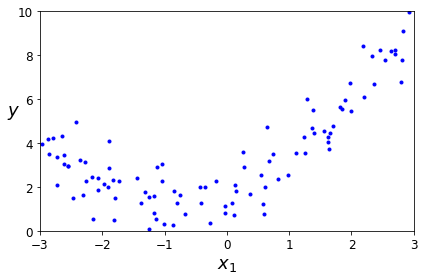

In [63]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

To begin modeling this data w/ sklearn, we use the `PolynomialFeatures` class to transform the training data so that higher powers of each feature serve as new features themselves (just one additional feature in the quadratic case).  Recall that in linear regression $\bf x$ is just a vector, so we can make its components to be powers.

In [64]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [65]:
X_poly[0] # X and X^2

array([-0.75275929,  0.56664654])

Now apply a `LinearRegression` to the extended training data (multi-feature lin. reg.).

In [66]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Generated : $ y= 0.5 x_1^2 + x_1 + 2.0 + \epsilon$ 

Estimate : $ \hat y = 0.56 x_1^2 + 0.93 x_1 + 1.78 $

Saving figure quadratic_predictions_plot


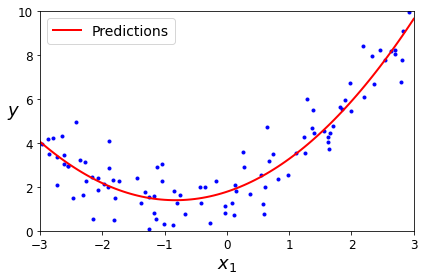

In [67]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

`PolynomialFeatures` of degree $d$ in fact produces all possible combinations of features up to power $d$. Hence, with two features $a$, $b$ and $d=3$, it will generate $a^3$, .. , $ab^2$, $a^2b$. In this sense, polynomial regression is thus sensitive to the relationship between $a$ and $b$ (loose statement here, but more aptly it is capable of modeling non-linearities). 

## Learning Curves

First take a look at different degrees of polynomial regression in this example.

Saving figure high_degree_polynomials_plot


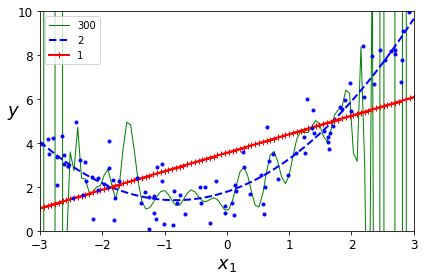

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

Linear model underfits, 300 degree poly. overfits, where as quadratic fits correctly (since data was quadratically generated). 

One way to assess overfitting is to do cross validation to estimate model's generalization performance. If performs well on training set but poorly on cross-val, then overfitting occuring. If performs poorly on both, underfitting.

Another method is to plot model performance on the training set and validation set as a function of the training set size, i.e. __learning curves__. Train model on different subsets of training set. 

In [71]:
# define fn to plot learning curves
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


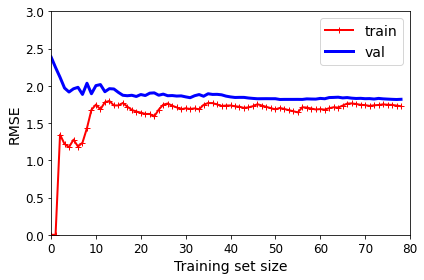

In [72]:
# single feature linear regression model
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

Re. training curve, linear model can generalize well for small sample sizes, but as they increase it has difficulty. Plateaus since additional points do not generally affect average error (as good as it gets). Re. validation curve, performs poorly on limited trained data, but with more examples learns, until again plateauing. 

Learning curves illustrating plateauing, high error, and close separation are an indication of *underfitting*. More training data will not improve the model.

Now try 10th degree polynomial. 

Saving figure learning_curves_plot


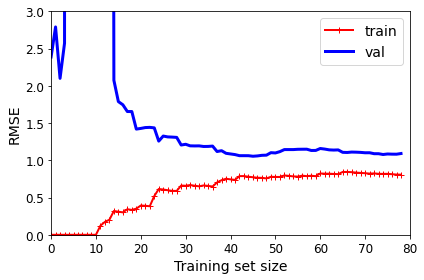

In [73]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig("learning_curves_plot")  # not shown
plt.show()                        # not shown

Note that error on training is much lower than linear model. Larger gap between curves, meaning it performs much better on training than validation - telltale sign of overfitting.

More data will improve the model. 

### The Bias/Variance Trade-Off

Theoretical result that a model's generalization error can be expressed as the sum of three different errors:

__Bias__ : Generalization error due to wrong assumptions, such as assuming data is linear when actually quadratic. High-bias model is most likely to underfit the training data. 

__Variance__ : Generaliation error due to model's excessive sensitivity to small variations in the training data. A model with many degrees of freedom is likely to have high variance and thus overfit the training data.

__Irreducible Error__ : Generalization error due to the noisiness itself. Can only be reduced by cleaning up the raw data. 

Typically, increasing a model's complexity will increase its variance and reduce its bias and conversely. Hence *trade-off*. Terms above are quite vague and poorly defined. I think overall this is just the concept of overfitting and underfitting based on model complexity. Generality (complexity) in model leads to high variance (fluctuations), whereas limitations in model miss general features. 

## Regularized Linear Models

To reduce overfitting, we need to contrain model. With polynomial regression, we can reduce degrees of freedom. More generally (as applied to all linear models), we will constrain the model weights.

Note that regularization terms are only added *during training*. In fact, it is common for the training error fn to differ from the testing error fn in regards such as optimization-friendly derivatives. (For ex, classifiers trained using log loss, but evaluated w/ precision recall). 

Also typically important to scale the data (e.g. `StandardScaler`) before performing regularized regression, as it is sensitive to the input features. 

### Ridge Regression 

Aka *Tikhonov regularization*. Add regularization term to error fn.

$$J(\theta) = MSE(\theta) + \alpha \frac{1}{2}\sum_{i=1}^n \theta_i^2 $$

Note bias term is unregularized. Defining $\theta_i = \mathbf w$, regularization term is equal to $\frac{1}{2} (|| \mathbf{w} ||_{2})^2$, with $|| \mathbf{w}||_2$ the $\ell_2$ norm. 

Ridge regression can be solved via closed form solution or gradient descent. To implement closed-form via sklearn, we use a variant based on a matrix factorization technique by Cholesky

In [79]:
# initial setup, ignore
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [80]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

Ridge regression using SGD, note $\ell_2$ regularizer

In [81]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

Lets generate some different Ridge models trained on linear data, based on different $\alpha$'s. 

Saving figure ridge_regression_plot


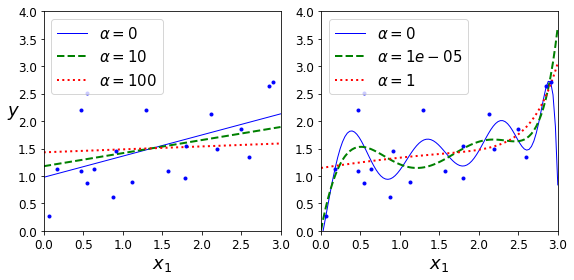

In [77]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In left pane, single model param (linear) leads to linear predictions. On the right pane, we have polynomial regression with $d=10$. Note how larger $\alpha$ leads to more reasonable predictions (reducing the model's variance, but increasing its bias, (apparently)).

### Lasso Regression

*Least Absolute Shrinkage and Selection Operator Regression*, aka Lasso, uses $\ell_1$ norm.

$$J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^n |\theta_i|$$

Generating similar plot, but using small $\alpha$ values. 

/home/mgp/Coding-Exercises/ml/geron/jup_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


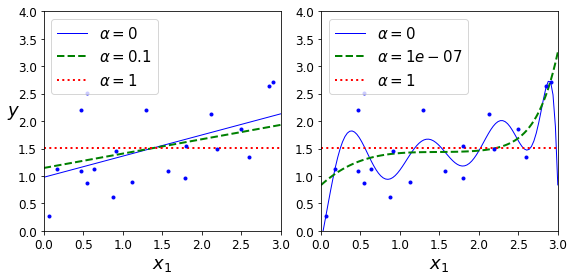

In [82]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In comparison to $\ell_2$ norm, Lasso will has a higher propensity to eliminate weights of least important features, which can be noted in dashed red right pane (linear model). In this sense it performs feature selection and outputs a __sparse model__ (few non-zero feature weights). 

To avoid Gradient Descent from bouncing around the optimum atthe end when using Lasso, you need to gradually reduce the learning  rate  during  training  (it  will  still  bounce  around  the  optimum, but the steps will get smaller and smaller, so it will converge).

See discussion around Figure 4-19 for some comparison of $\ell_2$ and $\ell_1$. Perhaps consulting another resource helpful here.

Lasso error fn is not differentiable at zero, thus one must use a *subgradient vector* for gradient descent. 

In [83]:
# Simple Lasso example
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### Elastic Net

Mix between Ridge and Lasso, with controllable mix ratio $r$

$$J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^n |\theta_i| + \frac{1-r}{2}\theta_i^2$$

Typically it is usually good to use some sort of regularization rather than none. Ridge is good default, but if suspect some features not useful, Lasso or Elastic Net. Generally, Elastic preferred over Lasso, since Lasso may behave erratically  when  the  number  of  features  is  greater  than  the  number  of training instances or when several features are strongly correlated.

In [84]:
# Simple Elastic Net example
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### Early Stopping

Another regularization method for iterative gradient descent learning algorithms is __early stopping__, where we aim to stop training as soon as the *validation error* reaches a minimum. 

As such a simple and efficient regularization technique that Geoffrey Hinton called it a “beautiful free lunch.”

In [90]:
# Example of early stopping; note use of warm start for continuous training
# Ends after increase in error at epoch resolution
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

Saving figure early_stopping_plot


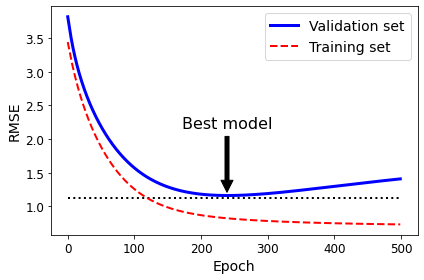

In [91]:
# Don't mind code below, needed to make image
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
        
# Create the graph
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

Once validation error starts going back up, model is overfitting the training data. 

\**With  Stochastic  and  Mini-batch  Gradient  Descent,  the  curves  are not  so  smooth,  and  it  may  be  hard  to  know  whether  you  have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time (when you  are  confident  that  the  model  will  not  do  any  better),  then  rollback the model parameters to the point where the validation error was at a minimum.*

## Logistic Regression

**Logistic regression** estimates the probability that an instance belongs to a given class, with threshold at 50%. It is thus a *binary classifier*. 

### Estimating Probabilities

Similar to linear regression, logistic regression computes a weighted sum (plus bias term) of its input features. Output is then wrapped with a logistic fn $\sigma = \frac{1}{1 + e^{-t}}$ (no such fn in linear regres.). 

Logistic model estimated probability: $$\hat p = h_\theta(\bf x) = \sigma(\bf x^T\theta) $$

Decision: $$ \hat y = \begin{cases} 0\ \rm{if}\ \hat p \lt 0.5 \\ 1\ \rm{if}\ \hat p \ge 0.5\end{cases}$$

With $\sigma(t) < 0.5$ when $t\lt0$ and $\sigma(t)\ge 0.5$ when $t\ge0$, the logistic fn predicts $1$ if $\mathbf{x}^T\theta \gt 0$ and $0$ if negative. 

The logit function is $logit(p) = \log\left( \frac{p}{1-p}\right)$, which is the inverse of the logistic fn $\sigma$. 

As such, $t$ in the above is considered the *logit*, also known as *log-odds* since  it  is  the  log  of  the  ratio between  the  estimated  probability  for  the  positive  class  and  the estimated probability for the negative class.

### Training and Cost Function

We seek to vary model weights so as to produce estimates of high probabilities for positive instances $y=1$ and low probabilities for negative instances $y=0$. What error fn to use to find ideal $\bf w$? Consider

$$ c(\theta) = \begin{cases} -\log(\hat p)\ \rm{if}\ y=1\\ -\log(1-\hat p)\ \rm{if}\ y=0\end{cases}$$

Since our targets are discrete and binary, the error fn associated with a *single instance*, $c(\theta)$ is piecewise. Note that $-\log(\hat p)$ diverges to $+\infty$ at $\hat p = 0$ and goes to $0$ at $\hat p = 1$. This serves as an appropriate measure of error we seek to minimize

Averaging $c(\theta)$ over the set of all instances, we arrive at the *log-loss* logistic regression error fn., expressed in the conveinent form:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m\left[ y^{(i)}\log \hat{p}^{(i)} + (1-y^{(i)})\log(1-\hat{p}^{(i)})\right]$$

No closed form solution, but the *log-loss* is convex, and thus grad. desc. guaranteed to reach global min (if learning rate not too large and given enough time). 

Variation w.r.t. $j$th feature:

$$\frac{\partial}{\partial \theta_j}J(\theta) = \frac{1}{m}\sum_{i=1}^m (\sigma(\theta^T\mathbf{x}^{(i)})-y^{(i)}) x_j^{(i)}$$

Very similar to variation from linear regression.

### Decision Boundaries

Use *Iris* dataset, which contains  the  sepal  and  petal  length  and  width  of  150  iris  flowers  of  three  different species.

Build a classifier to detect *Iris virginica* based on petal width. 

In [100]:
from sklearn import datasets
iris = datasets.load_iris()
print(list(iris.keys()))
#print(iris['DESCR'])

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']


In [108]:
X = iris["data"][:, 3:]  # petal width (remember, 3: (slice) diff. from 3)
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

Train a logistic model

In [109]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

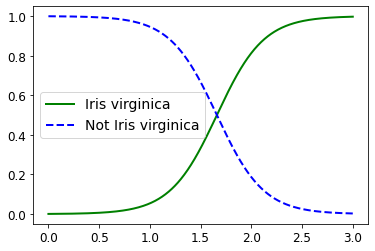

In [120]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1) #-1 infers length of array, nice!
y_proba = log_reg.predict_proba(X_new)

# Simple plot
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.legend(loc="center left", fontsize=14)
plt.show()

Decision boundary here lies about 1.6 cm. If `predict` was used instead, output is most likely class, at 50% threshold. 

In [122]:
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
decision_boundary

array([1.66066066])

In [124]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

Note that $\sigma(\theta^T \mathbf x = 0) = 0.5$. Hence the decision boundary is the set of points by which $\theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... = 0$, and thus will always form a line (or hyperplane). Logistic regression may be thought of as a simple linear regression model, wrapped with a sigmoid which is monotonic and simply compresses the range to $[0, 1]$. 

Decision boundary based now on two features, petal length and width

Saving figure logistic_regression_contour_plot


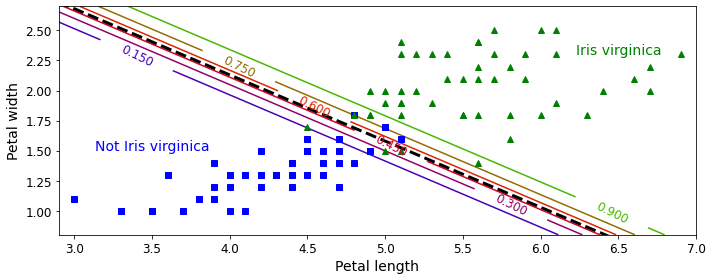

In [125]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

As with linear reg., logi. regr. can be regularized by $\ell_1$ or $\ell_2$ penalties. Sklearn uses $\ell_2$ by default with adjustable param $C = \frac{1}{\alpha}$. 

### Softmax Regression

To support multiple class classification (single output prediction, without using a series of binary classifiers), one may generalize logistic regression by use of the **softmax regression** model aka **multinomial logistic regression**. Note, classes must be mutually exclusive as softmax reg. is not multi-output.

First compute the *softmax score* for an instance $\mathbf x$

$$ s_k(\theta) = \mathbf x^T \theta^{(k)} $$

Note that $\theta^{(k)} \equiv \Theta$ is a matrix of params, each row or col a vector.

Next compute the probability of class $k$ by passing score vector into the *softmax function*

$$ \hat p_k = \sigma(s(\mathbf x))_k = \frac{\exp(s_k(\mathbf x))}{\sum_j \exp(s_j(\mathbf x))} $$

The softmax, aka *logits* or *unnormalized log odds*, computes the exponential and normalizes the result. For a better picture between the connection of logistic regression $K=2$ and softmax regression $K\gt 2$, see Bishop 197.

Classifier prediction: $ \hat y= \underset{k}{argmax}\  \sigma(s(\mathbf x))_k  =\underset{k}{argmax}\  s_k(\mathbf x) = \underset{k}{argmax}\  \theta^{(k)}{}^T \mathbf x$  

Returns the class with highest probability

The appropriate error fn to minimize is that of **cross entropy loss**:

$$ J(\Theta) = -\frac{1}{m} \sum_i^m \sum_k^Ky_k^{(i)}\log( \hat p_k^{(i)}) $$

Note that the target $y_k^{(i)} \in \{0, 1\}$ and for $K=2$ reduces to the *log-loss* of logistic regres. We want to maximize the summand, which amounts to assigning maximal $\hat p_k^{(i)}$ to those instances with $y_k^{(i)}=1$.

Has roots in information theory, best resourced in Bishop probably. 

Cross entropy gradient vector for class $k$

$$\nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m} \sum_i^m(\hat p_k^{(i)} - y_k^{(i)})\mathbf x^{(i)} $$

Sklearn's `LogisticRegression` uses one-versus-the-rest by default when you train it on more than two classes, but one can set the `multi_class` hyperparameter to `multinomial` to switch it to Softmax Regression. Must also specify a solver that supports Softmax Regression (such as the `lbfgs` solver); applies $\ell_2$ regularization by default, controlled with hyperparameter `C`

In [126]:
# Lets do softmax regression to predict 3 possible flower types based on petal dims
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [127]:
softmax_reg.predict([[5, 2]])

array([2])

In [128]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

Saving figure softmax_regression_contour_plot


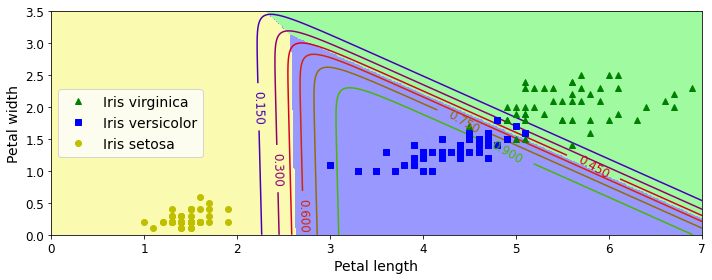

In [129]:
# Plot code, not priority
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

Decision boundaries. Note decision boundary between any *two* given classes is linear. Contours of const. probability for the *Iris veriscolor* class are shown. Vertex represent equal-class probability (33%). 